In [ ]:
# Import necessary libraries
import zipfile
import os
import cv2
import imghdr
import tensorflow as tf
import numpy as np
import random
from matplotlib import pyplot as plt
from google.colab import files
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, PReLU, LeakyReLU, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers, activations
from tensorflow.keras import backend as K

In [ ]:
# Unzip the compressed data
# Upload the zip file
uploaded = files.upload()

# Specify the name of the uploaded zip file and the destination directory
zip_file_name = 'archive (17).zip'
destination_directory = 'extraction_directory'

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(destination_directory)

Saving archive (17).zip to archive (17).zip


In [ ]:
# Verify the number of images in the file path(s)
path1 = '/content/extraction_directory/train/REAL'
path2 = '/content/extraction_directory/train/FAKE'
path3 = '/content/extraction_directory/test/REAL'
path4 = '/content/extraction_directory/test/FAKE'

def count_files_in_directory(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

count1 = count_files_in_directory(path1)
count2 = count_files_in_directory(path2)
count3 = count_files_in_directory(path3)
count4 = count_files_in_directory(path4)

print(f"Number of files in path 1: {count1}")
print(f"Number of files in path 2: {count2}")
print(f"Number of files in path 3: {count3}")
print(f"Number of files in path 4: {count4}")

Number of files in path 1: 50000
Number of files in path 2: 50000
Number of files in path 3: 10000
Number of files in path 4: 10000


In [ ]:
# Verify the image shape

img = cv2.imread('/content/extraction_directory/test/FAKE/0 (10).jpg')

img.shape

(32, 32, 3)

In [ ]:
# Set the random seeds
seed = 250
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# Define image dimensions and batch size
img_width, img_height = 32, 32
batch_size = 32

# Function to load and preprocess data
def load_and_preprocess_data(path, target_size, batch_size, class_mode, subset):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

    generator = datagen.flow_from_directory(
        path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset=subset
    )

    return generator

In [ ]:
def create_improved_model():
    # Set your seed and image dimensions
    tf.random.set_seed(seed)

    # Input layer
    input_layer = Input(shape=(img_width, img_height, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)

    # Stack of convolutional layers with skip connections
    for filters in [64, 128, 256, 512]:
        # First branch with convolution
        x1 = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x1 = MaxPooling2D((2, 2))(x1)

        # Second branch with skip connection
        x2 = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x2 = MaxPooling2D((2, 2))(x2)

        # Merge branches with skip connection
        x = Add()([x1, x2])

    x = Flatten()(x)

    # Fully connected layers with PReLU activation
    x = Dense(256)(x)
    x = PReLU()(x)
    x = Dropout(0.1)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Function to train the model
def train_model(model, train_generator, test_generator, epochs, callbacks):
    history = model.fit(train_generator, epochs=epochs, validation_data=test_generator, callbacks=[tensorboard_callback])

    return history

In [ ]:
# Load and preprocess the images for training and testing
train_generator = load_and_augment_data('/content/extraction_directory/train', (img_width, img_height), batch_size, 'binary', 'training', apply_augmentation)
test_generator = load_and_preprocess_data('/content/extraction_directory/test', (img_width, img_height), batch_size, 'binary', None)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
resinput = (32, 32, 3)
resclasses = 1

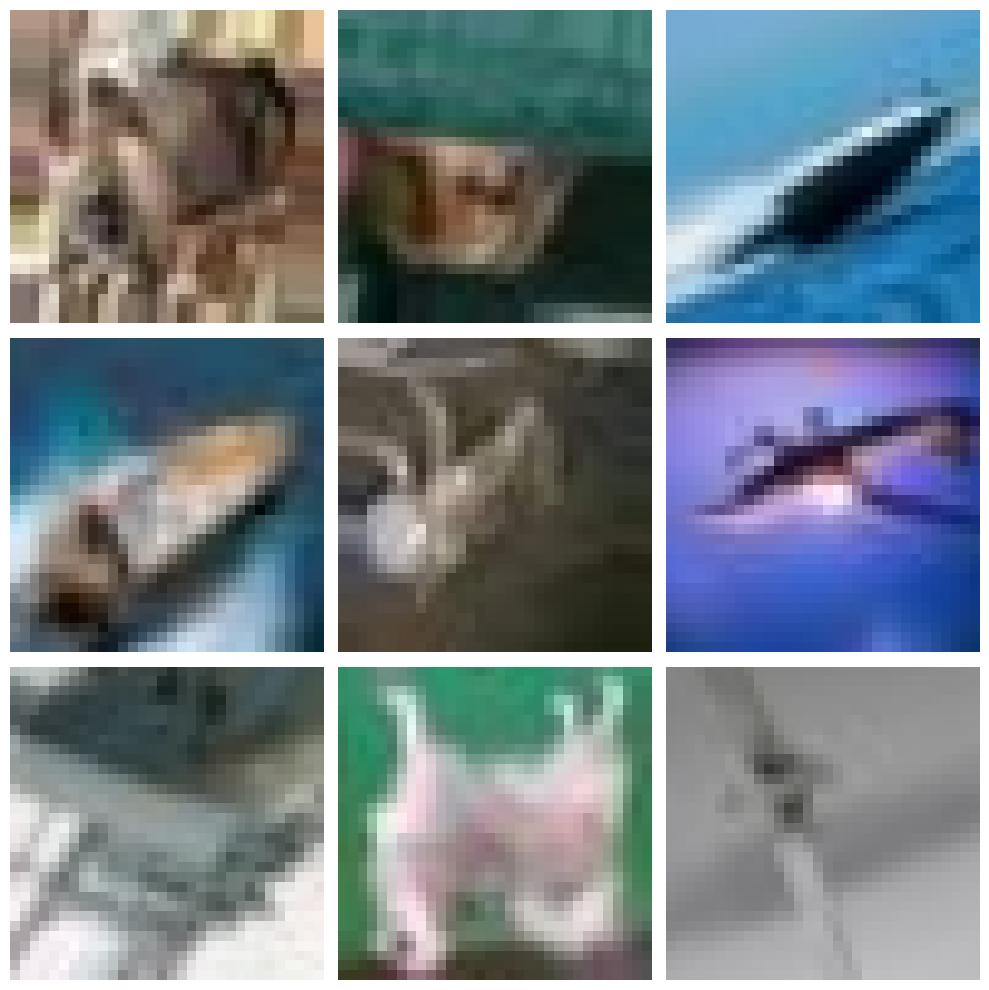

In [ ]:
# Generate a batch of augmented images
sample_images, _ = next(train_generator)

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):  # Plot the first 9 images from the batch
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')  # Turn off axis labels
plt.tight_layout()
plt.show()

In [ ]:
# Create the model

model = create_improved_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 32, 32, 32)           896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 32)           0         ['conv2d_8[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 16, 16, 64)           18496     ['max_pooling2d_8[0][0]'] 

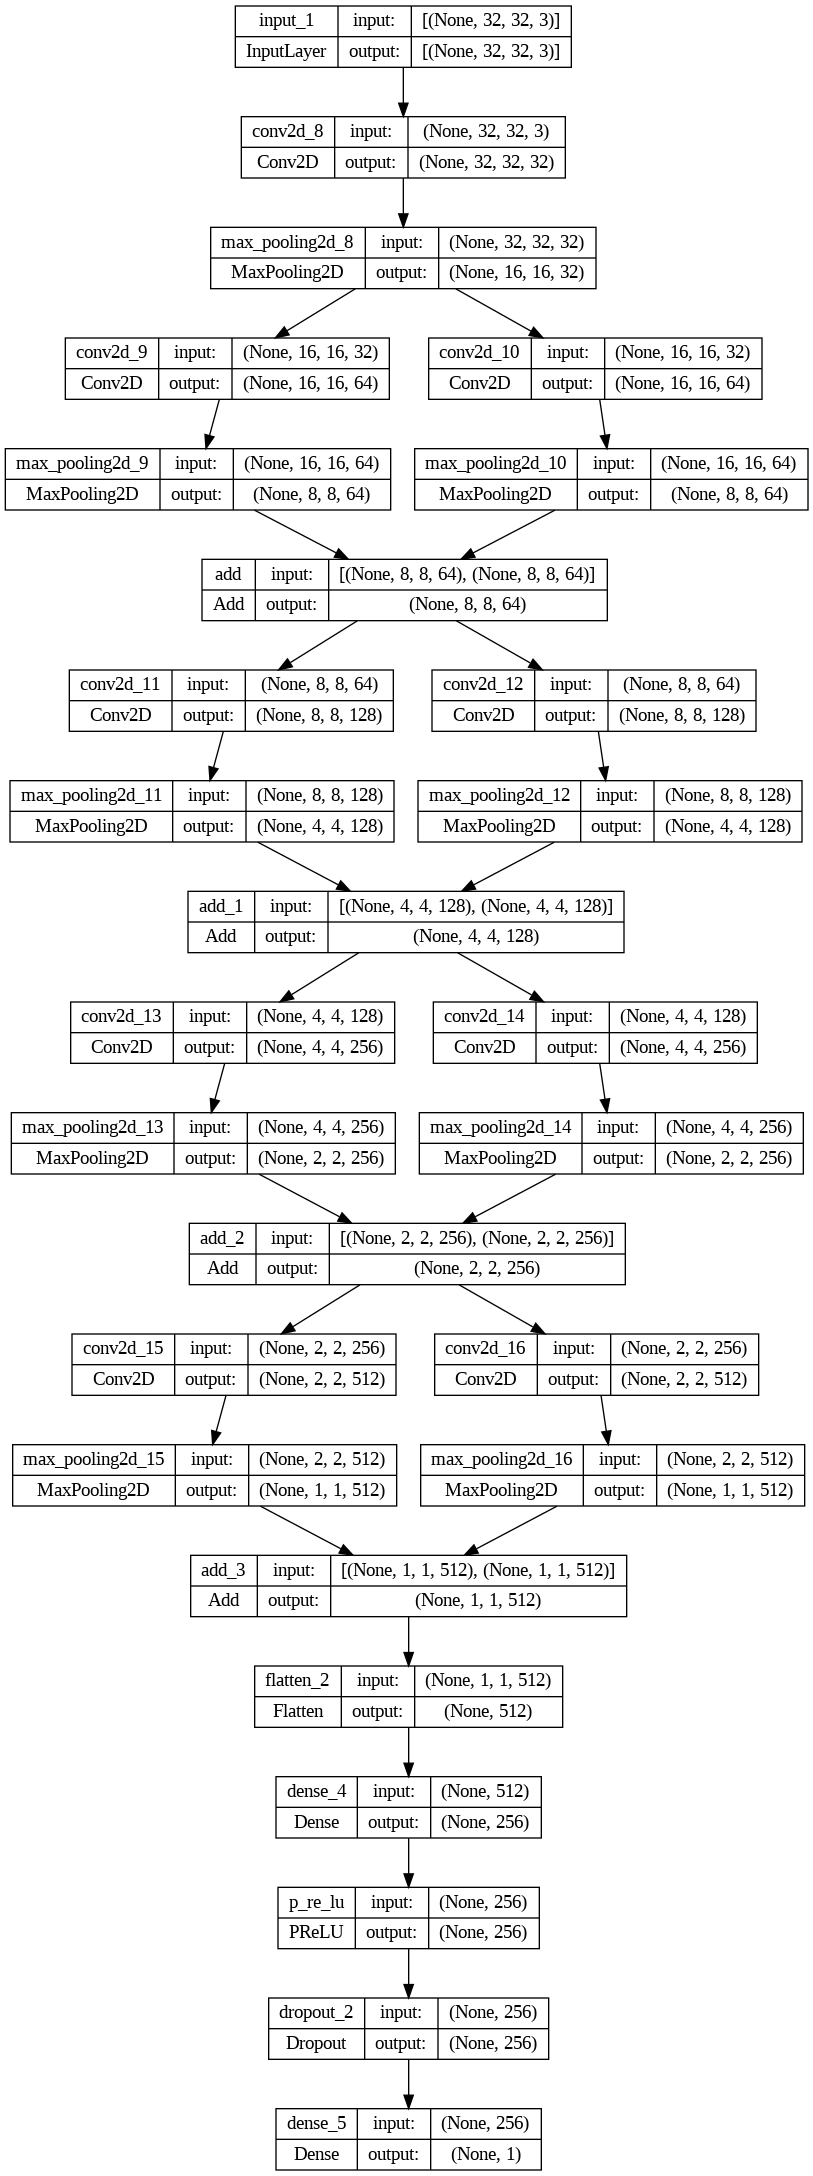

In [ ]:
# Plot the model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Set the log directory
logdir = 'logs'

In [ ]:
# Assign the callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# Train the model
epochs = 30
history = train_model(model, train_generator, test_generator, epochs, callbacks=[tensorboard_callback])

Epoch 1/30
3125/3125 [==============================] - 133s 42ms/step - loss: 0.4967 - accuracy: 0.8093 - val_loss: 0.4462 - val_accuracy: 0.8207
Epoch 2/30
3125/3125 [==============================] - 132s 42ms/step - loss: 0.3887 - accuracy: 0.8498 - val_loss: 0.4734 - val_accuracy: 0.8066
Epoch 3/30
3125/3125 [==============================] - 131s 42ms/step - loss: 0.3680 - accuracy: 0.8604 - val_loss: 0.4623 - val_accuracy: 0.8102
Epoch 4/30
3125/3125 [==============================] - 131s 42ms/step - loss: 0.3569 - accuracy: 0.8656 - val_loss: 0.4543 - val_accuracy: 0.8184
Epoch 5/30
3125/3125 [==============================] - 126s 40ms/step - loss: 0.3444 - accuracy: 0.8718 - val_loss: 0.4148 - val_accuracy: 0.8404
Epoch 6/30
3125/3125 [==============================] - 129s 41ms/step - loss: 0.3371 - accuracy: 0.8755 - val_loss: 0.5369 - val_accuracy: 0.7883
Epoch 7/30
3125/3125 [==============================] - 132s 42ms/step - loss: 0.3344 - accuracy: 0.8774 - val_loss: 0

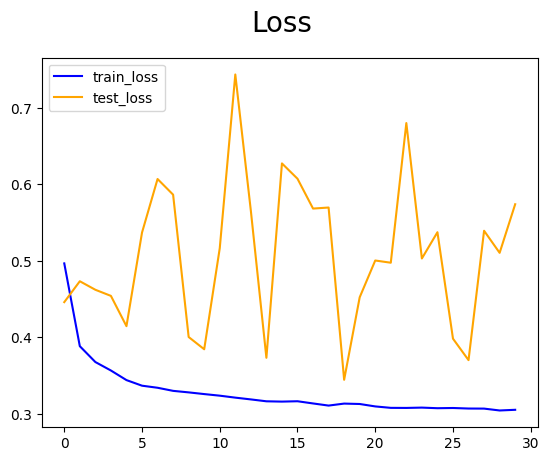

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='blue', label='train_loss')
plt.plot(history.history['val_loss'], color='orange', label='test_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

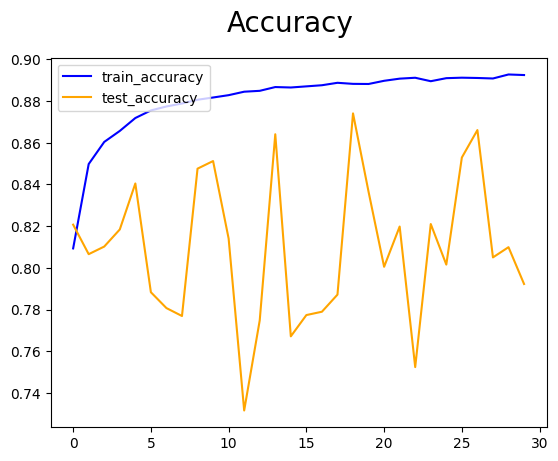

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='train_accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='test_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Save the model
model.save('/content/zetaclassifier.h5')

In [ ]:
# Load the model and test against images
depmodel = load_model('/content/epsilonlassifier.h5')

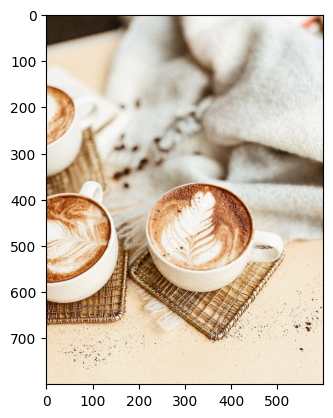

In [ ]:
# Load and view the images
img = cv2.imread('/content/real71.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [ ]:
# Resive the images
resize = tf.image.resize(img, (32,32))

In [ ]:
# Make a prediction
y_pred = depmodel.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 122ms/step


In [ ]:
y_pred

array([[2.6724933e-10]], dtype=float32)

In [ ]:
if y_pred > 0.5:
  print(f'Real')
else:
  print(f'Fake')

Fake
